In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 32.7 MB/s 


In [2]:
#%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
import pydicom as dcm
from glob import glob
from skimage.transform import resize
from skimage import io, measure
import cv2, random

import tensorflow as tf
from tensorflow import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

train_labels= pd.read_csv("/content/drive/MyDrive/stage_2_train_labels.csv/stage_2_train_labels.csv")
class_labels = pd.read_csv("/content/drive/MyDrive/stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv")


In [5]:
images_path = '../content/drive/MyDrive/stage_2_train_images/stage_2_train_images'

In [6]:
print(train_labels.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [7]:
print(train_labels.iloc[10])

patientId    008c19e8-a820-403a-930a-bc74a4053664
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 10, dtype: object


In [8]:
print(train_labels.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                           264.0
y                                           152.0
width                                       213.0
height                                      379.0
Target                                          1
Name: 4, dtype: object


In [9]:
print(train_labels.iloc[5])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                           562.0
y                                           152.0
width                                       256.0
height                                      453.0
Target                                          1
Name: 5, dtype: object


In [10]:
train_labels.shape

(30227, 6)

In [11]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


The stage_2_detailed_class_info CSV contains the following information

patientId : For uniquely identifying the patient whose X-ray scan is in the image dataset
class : detailed class info wherein there are three categories in picture
Normal : No pneumonia (Target = 0)
Lung Opacity : Pneumonia (Target = 1)
No Lung Opacity/ Not Normal : Inflammation not leading to Pneumonia (Target = 0)

In [12]:
print('The train_label dataframe has {} rows and {} columns.'.format(train_labels.shape[0], train_labels.shape[1]))

The train_label dataframe has 30227 rows and 6 columns.


In [13]:
# Number of duplicates in patientId:
print('Number of unique patientId are: {}'.format(train_labels['patientId'].nunique()))

Number of unique patientId are: 26684


In [14]:
import pydicom

patientId = train_labels['patientId'][0]
dcm_file = f'../content/drive/MyDrive/stage_2_train_images/{patientId}.dcm'
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [15]:
img = dcm_data.pixel_array
print(type(img))
print(img.dtype)
print(img.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


In [16]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [17]:
class_labels.shape

(30227, 2)

In [18]:
class_labels.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [19]:
class_labels['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [20]:
print('Size of Dataset 1: ',train_labels.shape)
print('Size of Dataset 2: ',class_labels.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',class_labels['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (30227, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


In [21]:
merged = pd.merge(left = train_labels, right = class_labels, how = 'left', on = 'patientId') # Merge
merged = merged.drop_duplicates() # Remove duplicates

merged.head(10)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
8,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
10,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity
12,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity


In [22]:
merged.shape

(30227, 7)

In [23]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37627
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [24]:
merged.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

In [25]:
pd.pivot_table(merged,index=["Target"], values=['patientId'], aggfunc='count')

,patientId
Target,
0,20672
1,9555


In [26]:
pd.pivot_table(merged,index=["class"], values=['patientId'], aggfunc='count')

,patientId
class,
Lung Opacity,9555
No Lung Opacity / Not Normal,11821
Normal,8851


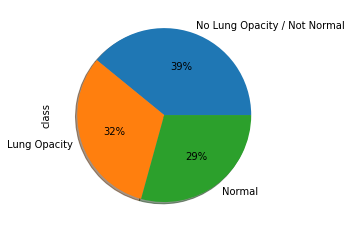

In [27]:
merged["class"].value_counts().plot(kind='pie',autopct='%1.0f%%', shadow=True, subplots=False)

In [28]:
pd.pivot_table(merged,index=["Target"], aggfunc='count')

,class,height,patientId,width,x,y
Target,,,,,,
0,20672,0,20672,0,0,0
1,9555,9555,9555,9555,9555,9555


In [29]:
merged['patientId'].value_counts().value_counts()

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64

In [30]:
merged[merged['Target'] == 0]['patientId'].value_counts().value_counts()

1    20672
Name: patientId, dtype: int64

In [31]:
merged[merged['Target'] == 1]['patientId'].value_counts().value_counts()

2    3266
1    2614
3     119
4      13
Name: patientId, dtype: int64

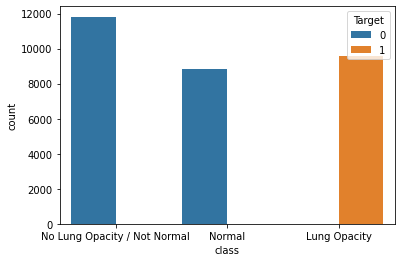

In [32]:
sns.countplot(x = 'class', hue = 'Target', data = merged)

In [33]:
 merged.fillna(0.0)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
37621,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity
37623,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0.0,0.0,0.0,0.0,0,Normal
37624,c1f6b555-2eb1-4231-98f6-50a963976431,0.0,0.0,0.0,0.0,0,Normal
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity


In [34]:
merged.corr()

,x,y,width,height,Target
x,1.000000,0.007604,-0.058665,0.008256,NaN
y,0.007604,1.000000,-0.299897,-0.645369,NaN
width,-0.058665,-0.299897,1.000000,0.597461,NaN
height,0.008256,-0.645369,0.597461,1.000000,NaN
Target,NaN,NaN,NaN,NaN,1.0


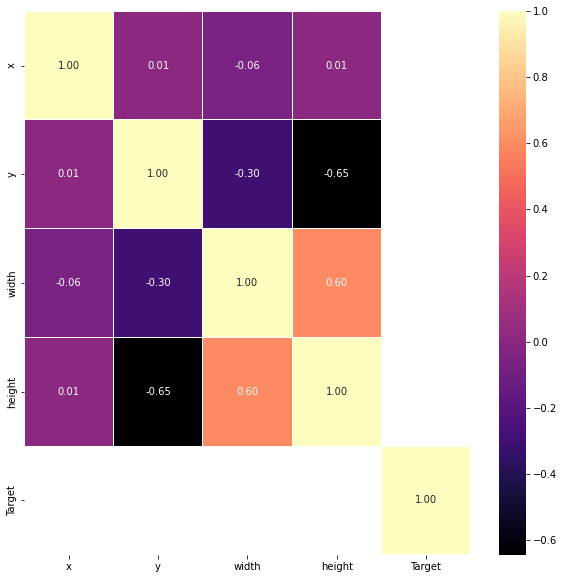

In [35]:
fig,ax = plt.subplots(figsize=(10, 10))   
sns.heatmap(merged.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma") 
plt.show()

In [36]:
# Checking nulls in bounding box columns:
print('Number of nulls in bounding box columns: {}'.format(merged[['x', 'y', 'width', 'height']].isnull().sum().to_dict()))

Number of nulls in bounding box columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}


In [37]:
bounding_box = merged.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
merged_labels = merged.merge(bounding_box, on = 'patientId', how = 'left')
print('Number of patientIds per bounding box in the dataset: ')
(bounding_box.groupby('number_of_boxes').size().to_frame('number_of_patientId').reset_index().set_index('number_of_boxes').sort_values(by = 'number_of_boxes'))

Number of patientIds per bounding box in the dataset: 


,number_of_patientId
number_of_boxes,
1,23286
2,3266
3,119
4,13


In [ ]:
a = merged.loc[merged['class'] == "No Lung Opacity / Not Normal"]

a['Target'].value_counts()

0    11821
Name: Target, dtype: int64

In [38]:
import skimage
from skimage import feature, filters

# How many unique features?
print(f"Unique features: \n{merged.nunique()}")

Unique features: 
patientId    26684
x              748
y              726
width          351
height         725
Target           2
class            3
dtype: int64


In [39]:
neg, pos = merged["Target"].value_counts()

print(f'Data classification: \n{merged["Target"].value_counts()}\n')

print(f'we can say that  {round(pos/(pos+neg)*100, 2)}% having pneumonia within this training data')

Data classification: 
0    20672
1     9555
Name: Target, dtype: int64

we can say that  31.61% having pneumonia within this training data


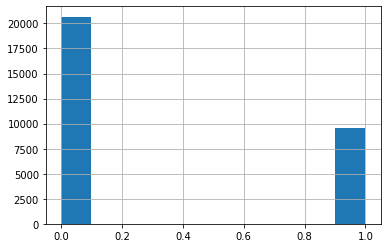

In [40]:
# See how many people with pneumonia vs non-pneumonia
merged['Target'].hist()

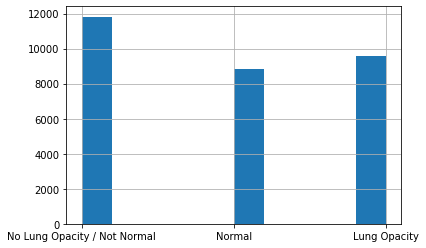

In [41]:
# Look at the amounts in each of the different classes
merged['class'].hist();

(-0.5, 1023.5, 1023.5, -0.5)

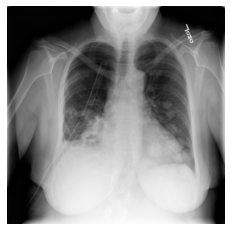

In [42]:
plt.imshow(img)#, cmap=pylab.cm.gist_gray)
plt.gray()
plt.axis('off')

In [ ]:
train_labels = train_labels.drop_duplicates("patientId")
train_labels

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0


In [55]:
import os

train_labels_pos = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height'])

k = 0
for i in range(len(train_labels)):
    if train_labels.loc[i]['Target'] == 1:
        train_labels_pos.loc[k] = train_labels.loc[i]
        k += 1

print('Positive instances dataframe shape:', train_labels_pos.shape)
train_paths = [os.path.join(images_path, image[0]) for image in train_labels_pos.values]

Positive instances dataframe shape: (9555, 5)


In [56]:
train_labels_pos.head()

,patientId,x,y,width,height
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0
1,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0
2,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0
3,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0
4,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0


In [83]:
images_path = '/content/drive/MyDrive/stage_2_train_images/stage_2_train_images'

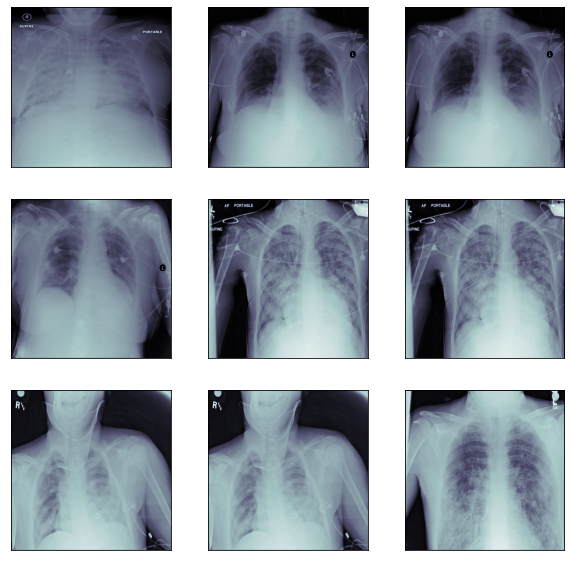

In [75]:
from pydicom import dcmread

def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap='bone')

imshow()

FileNotFoundError: ignored

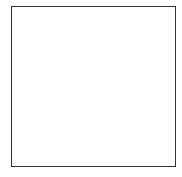

In [84]:
def show_image_with_bboxes(num_to_show=9):
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        id_= np.random.choice(train_labels_pos['patientId'].values)

        current_axis = plt.gca()
        img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
        plt.imshow(img,cmap='bone')


        current_axis = plt.gca()
        boxes=train_labels_pos[['x','y','width','height']][train_labels_pos['patientId']==id_].values

        for box in boxes:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            current_axis.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3)) 
        
show_image_with_bboxes()

<Figure size 432x288 with 0 Axes>

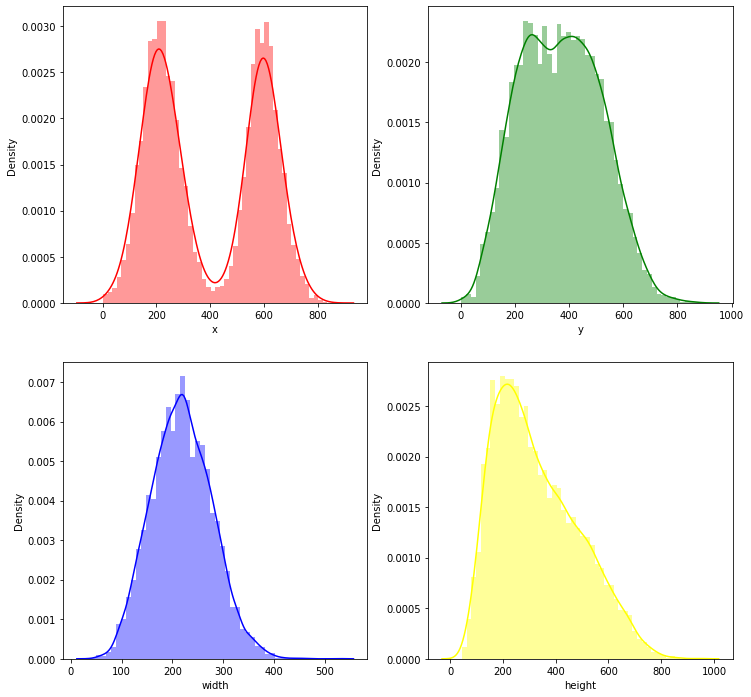

In [69]:
target1 = train_labels[train_labels['Target']==1]
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="green", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="blue", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="yellow", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both')
plt.show()

In [ ]:
def fetch_image_details(i,data_row,f, ax):
        patientImage = data_row['patientId']+'.dcm'
        
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))

def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        fetch_image_details(i,data_row,f, ax)
    plt.show()

In [70]:
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        fetch_image_details(i,data_row,f, ax)
        rows = train_labels[train_labels['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(patches.Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'],  linewidth=2, edgecolor='r', facecolor='none'))
    plt.show()

NameError: ignored

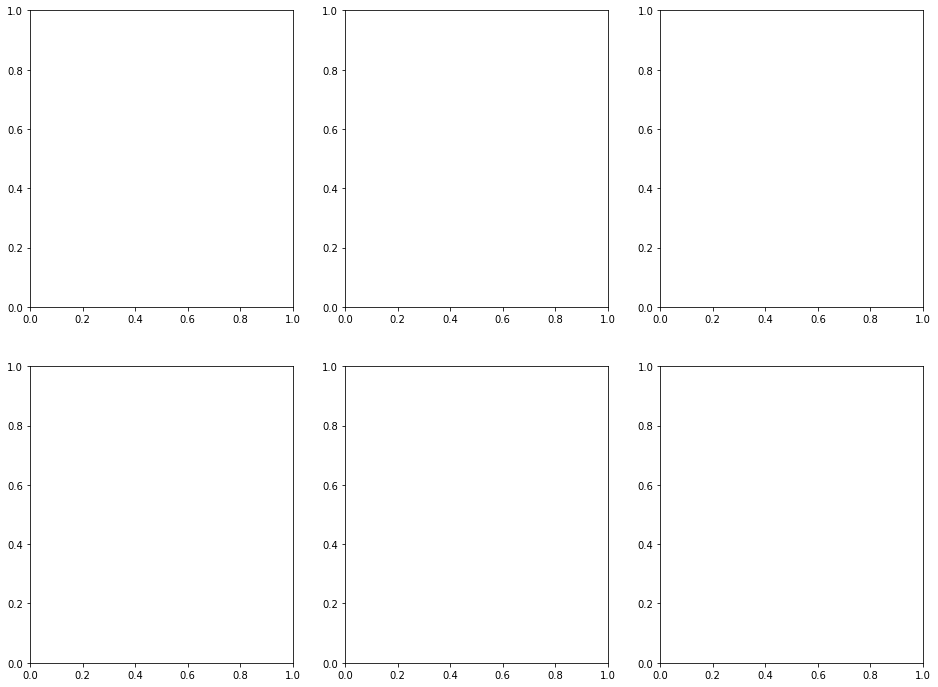

In [71]:
show_dicom_images_with_boxes(train_labels[train_labels['Target']==1].sample(6))